<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/ECG%20EDF%202%20HEADAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne wfdb -q

import mne
import numpy as np
from scipy import signal
from datetime import datetime
import wfdb
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 101.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


In [2]:
def edf_to_wfdb_mne(edf_file_path, output_base_name, target_fs=500, max_channels=None, selected_channels=None):
    """Convert EDF to WFDB using MNE-Python"""
    try:
        # Read EDF file with MNE
        raw = mne.io.read_raw_edf(edf_file_path, preload=True)

        print(f"EDF file info:")
        print(f"Channels: {raw.info['ch_names']}")
        print(f"Sampling frequency: {raw.info['sfreq']} Hz")
        print(f"Duration: {raw.times[-1]:.2f} seconds")

        # Find ECG channels
        ecg_ch_indices = []
        ecg_ch_names = []

        for i, ch_name in enumerate(raw.info['ch_names']):
            ch_name_lower = ch_name.lower()
            if any(term in ch_name_lower for term in ['ecg', 'ekg', 'electrocardiogram']):
                ecg_ch_indices.append(i)
                ecg_ch_names.append(ch_name)

        if not ecg_ch_indices:
            print("No ECG channels found. Looking for standard ECG leads...")
            # Look for standard 12-lead ECG channels
            standard_leads = ['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
            for i, ch_name in enumerate(raw.info['ch_names']):
                ch_name_lower = ch_name.lower().replace(' ', '')
                if ch_name_lower in standard_leads:
                    ecg_ch_indices.append(i)
                    ecg_ch_names.append(ch_name)

        if not ecg_ch_indices:
            print("No ECG channels found. Using all channels.")
            ecg_ch_indices = list(range(len(raw.info['ch_names'])))
            ecg_ch_names = raw.info['ch_names']

        # If specific channels are selected, filter them
        if selected_channels:
            filtered_indices = []
            filtered_names = []
            for i, (idx, name) in enumerate(zip(ecg_ch_indices, ecg_ch_names)):
                if name in selected_channels or name.lower() in [ch.lower() for ch in selected_channels]:
                    filtered_indices.append(idx)
                    filtered_names.append(name)
            if filtered_indices:
                ecg_ch_indices = filtered_indices
                ecg_ch_names = filtered_names
                print(f"Selected channels: {ecg_ch_names}")
            else:
                print("No matching channels found in selected_channels, using original selection")

        # Limit number of channels if specified
        if max_channels and len(ecg_ch_indices) > max_channels:
            print(f"Limiting to first {max_channels} channels")
            ecg_ch_indices = ecg_ch_indices[:max_channels]
            ecg_ch_names = ecg_ch_names[:max_channels]

        print(f"Using channels: {ecg_ch_names}")

        # Extract data
        data, times = raw[ecg_ch_indices, :]
        data = data.T  # Convert to (samples, channels)
        original_fs = raw.info['sfreq']

        # Resample if needed
        if original_fs != target_fs:
            print(f"Resampling from {original_fs} Hz to {target_fs} Hz")
            num_samples = int(data.shape[0] * target_fs / original_fs)
            data_resampled = np.zeros((num_samples, len(ecg_ch_indices)))

            for i in range(len(ecg_ch_indices)):
                data_resampled[:, i] = signal.resample(data[:, i], num_samples)
            data = data_resampled
            fs = target_fs
        else:
            fs = original_fs

        # Create WFDB record
        wfdb.wrsamp(
            record_name=output_base_name,
            fs=fs,
            units=['uV'] * len(ecg_ch_indices),
            sig_name=ecg_ch_names,
            p_signal=data,
            comments=[
                f"Converted from EDF using MNE: {edf_file_path}",
                f"Original sampling rate: {original_fs} Hz",
                f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
            ]
        )

        print(f"Successfully created WFDB files using MNE")
        print(f"Output channels: {len(ecg_ch_indices)}")
        return True

    except Exception as e:
        print(f"Error with MNE conversion: {e}")
        import traceback
        traceback.print_exc()
        return False

# Usage examples:

# For 12-lead ECG (your current file)
edf_to_wfdb_mne("/content/test_edf_ECG.edf", "output_12lead", target_fs=500)

# For specific leads only (if model expects specific leads)
selected_leads = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']  # Example - adjust based on your model's requirements
edf_to_wfdb_mne("/content/test_edf_ECG.edf", "output_selected", target_fs=500, selected_channels=selected_leads)

# For limiting to first 12 channels (if that's what the model expects)
edf_to_wfdb_mne("/content/test_edf_ECG.edf", "output_limited", target_fs=500, max_channels=12)

Extracting EDF parameters from /content/test_edf_ECG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 513  =      0.000 ...     5.130 secs...
EDF file info:
Channels: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
Sampling frequency: 100.00019455290769 Hz
Duration: 5.13 seconds
No ECG channels found. Looking for standard ECG leads...
Using channels: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
Resampling from 100.00019455290769 Hz to 500 Hz
Successfully created WFDB files using MNE
Output channels: 12
Extracting EDF parameters from /content/test_edf_ECG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 513  =      0.000 ...     5.130 secs...
EDF file info:
Channels: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
Sampling frequency: 100.00019455290769 Hz
Duration: 5.13 seconds
No ECG channels

True

In [3]:


def plot_wfdb_record(record_name, time_range=(0, 10), max_channels=12,
                    start_sample=None, end_sample=None,
                    title=None, figsize=None,
                    highlight_r_peaks=False):
    """
    Plot ECG data from WFDB HEA/DAT files

    Parameters:
    - record_name: path to .hea file (without extension)
    - time_range: tuple of (start_time, end_time) in seconds
    - max_channels: maximum number of channels to display
    - start_sample, end_sample: direct sample indices (overrides time_range)
    - title: custom title for the plot
    - figsize: custom figure size
    - highlight_r_peaks: whether to detect and highlight R-peaks
    """

    try:
        # Read WFDB record
        record = wfdb.rdrecord(record_name)

        # Extract data
        data = record.p_signal
        ch_names = record.sig_name
        fs = record.fs
        n_samples, n_channels = data.shape

        print(f"WFDB Record Info:")
        print(f"Record name: {record_name}")
        print(f"Channels: {n_channels}")
        print(f"Channel names: {ch_names}")
        print(f"Sampling frequency: {fs} Hz")
        print(f"Duration: {n_samples/fs:.2f} seconds")
        print(f"Data shape: {data.shape}")
        if record.comments:
            print(f"Comments: {record.comments}")

        # Determine sample range
        if start_sample is not None and end_sample is not None:
            start_idx, end_idx = start_sample, end_sample
        else:
            start_time, end_time = time_range
            start_idx = int(start_time * fs)
            end_idx = int(end_time * fs)

        # Ensure indices are within bounds
        start_idx = max(0, start_idx)
        end_idx = min(n_samples, end_idx)

        if start_idx >= end_idx:
            print("Invalid time range or sample indices")
            return

        # Extract data for the specified range
        plot_data = data[start_idx:end_idx, :]
        actual_duration = (end_idx - start_idx) / fs
        time = np.linspace(start_idx/fs, end_idx/fs, end_idx - start_idx)

        # Limit number of channels for better visualization
        if plot_data.shape[1] > max_channels:
            print(f"Plotting first {max_channels} channels for better visualization")
            plot_data = plot_data[:, :max_channels]
            ch_names = ch_names[:max_channels]

        num_channels = len(ch_names)

        # Set figure size
        if figsize is None:
            figsize = (15, 2 * num_channels)

        # Create subplot
        fig, axes = plt.subplots(num_channels, 1, figsize=figsize)
        if num_channels == 1:
            axes = [axes]

        # Plot each channel
        for i in range(num_channels):
            axes[i].plot(time, plot_data[:, i], linewidth=0.8, color='black')
            axes[i].set_ylabel('Amplitude\n(µV)', fontsize=10)
            axes[i].set_title(f'{ch_names[i]}', fontsize=12, loc='left')
            axes[i].grid(True, alpha=0.3)

            # Highlight R-peaks if requested
            if highlight_r_peaks and num_channels <= 4:  # Only for few channels to avoid clutter
                r_peaks = detect_r_peaks(plot_data[:, i], fs)
                if len(r_peaks) > 0:
                    axes[i].scatter(time[r_peaks], plot_data[r_peaks, i],
                                  color='red', s=30, zorder=5, label='R-peaks')
                    axes[i].legend()

            # Add x-axis label only to the last subplot
            if i == num_channels - 1:
                axes[i].set_xlabel('Time (seconds)', fontsize=12)

            # Remove top and right spines for cleaner look
            axes[i].spines['top'].set_visible(False)
            axes[i].spines['right'].set_visible(False)

        # Set title
        if title is None:
            title = f"ECG Recording: {record_name}\nDuration: {actual_duration:.2f} seconds, "
            title += f"Sampling Rate: {fs} Hz"
        plt.suptitle(title, fontsize=14, y=0.98)

        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        plt.show()

        print(f"Successfully plotted {num_channels} channels from {actual_duration:.2f} seconds of data")

    except FileNotFoundError:
        print(f"Error: Could not find record {record_name}.hea or {record_name}.dat")
    except Exception as e:
        print(f"Error plotting WFDB record: {e}")
        import traceback
        traceback.print_exc()

def detect_r_peaks(signal, fs):
    """
    Simple R-peak detection using threshold method
    """
    try:
        # Normalize signal
        signal_norm = (signal - np.mean(signal)) / np.std(signal)

        # Simple peak detection
        # Find peaks above a threshold
        threshold = 2.0
        peaks = []

        # Simple approach: find local maxima above threshold
        for i in range(1, len(signal_norm) - 1):
            if (signal_norm[i] > signal_norm[i-1] and
                signal_norm[i] > signal_norm[i+1] and
                signal_norm[i] > threshold):
                peaks.append(i)

        # Remove closely spaced peaks (artifacts)
        if len(peaks) > 1:
            min_distance = int(0.2 * fs)  # Minimum 200ms between peaks
            filtered_peaks = [peaks[0]]
            for i in range(1, len(peaks)):
                if peaks[i] - filtered_peaks[-1] >= min_distance:
                    filtered_peaks.append(peaks[i])
            return np.array(filtered_peaks)

        return np.array(peaks)
    except:
        return np.array([])

def plot_wfdb_with_annotations(record_name, annotation_extension='atr',
                              time_range=(0, 10), max_channels=2):
    """
    Plot ECG data with annotations (beats, rhythms, etc.)

    Parameters:
    - record_name: path to .hea file (without extension)
    - annotation_extension: annotation file extension (usually 'atr')
    - time_range: tuple of (start_time, end_time) in seconds
    - max_channels: maximum number of channels to display
    """

    try:
        # Read record and annotations
        record = wfdb.rdrecord(record_name)
        annotation = wfdb.rdann(record_name, annotation_extension)

        # Extract data
        data = record.p_signal
        ch_names = record.sig_name
        fs = record.fs
        n_samples, n_channels = data.shape

        # Determine sample range
        start_time, end_time = time_range
        start_idx = int(start_time * fs)
        end_idx = int(end_time * fs)

        # Ensure indices are within bounds
        start_idx = max(0, start_idx)
        end_idx = min(n_samples, end_idx)

        # Extract data for the specified range
        plot_data = data[start_idx:end_idx, :]
        time = np.linspace(start_idx/fs, end_idx/fs, end_idx - start_idx)

        # Limit channels
        if plot_data.shape[1] > max_channels:
            plot_data = plot_data[:, :max_channels]
            ch_names = ch_names[:max_channels]

        num_channels = len(ch_names)

        # Filter annotations within time range
        ann_sample_indices = annotation.sample
        ann_symbols = annotation.symbol

        # Convert sample indices to time range
        mask = (ann_sample_indices >= start_idx) & (ann_sample_indices < end_idx)
        filtered_ann_samples = ann_sample_indices[mask] - start_idx
        filtered_ann_symbols = [ann_symbols[i] for i, m in enumerate(mask) if m]

        # Create plot
        fig, axes = plt.subplots(num_channels, 1, figsize=(15, 3 * num_channels))
        if num_channels == 1:
            axes = [axes]

        # Plot each channel
        for i in range(num_channels):
            axes[i].plot(time, plot_data[:, i], linewidth=0.8, color='black')
            axes[i].set_ylabel('Amplitude (µV)')
            axes[i].set_title(f'{ch_names[i]}')
            axes[i].grid(True, alpha=0.3)

            # Plot annotations
            if i == 0:  # Plot annotations on first channel
                for sample_idx, symbol in zip(filtered_ann_samples, filtered_ann_symbols):
                    if sample_idx < len(time):
                        axes[i].axvline(time[sample_idx], color='red', linestyle='--', alpha=0.7, linewidth=1)
                        axes[i].text(time[sample_idx], np.max(plot_data[:, i]), symbol,
                                   color='red', fontsize=12, verticalalignment='bottom')

            if i == num_channels - 1:
                axes[i].set_xlabel('Time (seconds)')

        plt.suptitle(f"ECG with Annotations: {record_name}", fontsize=14)
        plt.tight_layout()
        plt.show()

        # Print annotation summary
        print(f"Annotations in time range {time_range}:")
        unique_symbols = list(set(filtered_ann_symbols))
        for symbol in unique_symbols:
            count = filtered_ann_symbols.count(symbol)
            print(f"  {symbol}: {count} occurrences")

    except FileNotFoundError as e:
        print(f"Error: Could not find required files: {e}")
    except Exception as e:
        print(f"Error plotting WFDB record with annotations: {e}")

def get_wfdb_info(record_name):
    """
    Get detailed information about a WFDB record
    """
    try:
        record = wfdb.rdrecord(record_name)

        print("=" * 50)
        print(f"WFDB RECORD INFORMATION: {record_name}")
        print("=" * 50)
        print(f"Record Name: {record.record_name}")
        print(f"Sampling Frequency: {record.fs} Hz")
        print(f"Number of Signals: {record.n_sig}")
        print(f"Number of Samples: {record.sig_len}")
        print(f"Duration: {record.sig_len/record.fs:.2f} seconds")
        print(f"Signal Names: {record.sig_name}")
        print(f"Units: {record.units}")
        print(f"ADC Gain: {record.adc_gain}")
        print(f"Baseline: {record.baseline}")
        print(f"Initial Value: {record.init_value}")
        print(f"Storage Format: {record.fmt}")
        print(f"Checksum: {record.checksum}")
        print(f"Block Size: {record.block_size}")
        if record.comments:
            print(f"Comments: {record.comments}")
        print("=" * 50)

        return record

    except Exception as e:
        print(f"Error reading WFDB record info: {e}")
        return None

# Usage Examples:

# 1. Basic plotting
# plot_wfdb_record("your_record_name", time_range=(0, 10))

# 2. Plot specific sample range
# plot_wfdb_record("your_record_name", start_sample=0, end_sample=5000)

# 3. Plot with custom parameters
# plot_wfdb_record("your_record_name",
#                 time_range=(5, 15),
#                 max_channels=6,
#                 figsize=(12, 8),
#                 title="My Custom ECG Plot")

# 4. Plot with R-peak detection
# plot_wfdb_record("your_record_name",
#                 time_range=(0, 8),
#                 max_channels=2,
#                 highlight_r_peaks=True)

# 5. Get record information
# get_wfdb_info("your_record_name")

# 6. Plot with annotations (if available)
# plot_wfdb_with_annotations("your_record_name", time_range=(0, 20))

WFDB Record Info:
Record name: output_ecg
Channels: 12
Channel names: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
Sampling frequency: 500 Hz
Duration: 5.14 seconds
Data shape: (2569, 12)
Comments: ['Converted from EDF using MNE: /content/test_edf_ECG.edf', 'Original sampling rate: 100.00019455290769 Hz', 'Date: 2025-08-20 13:04:44']


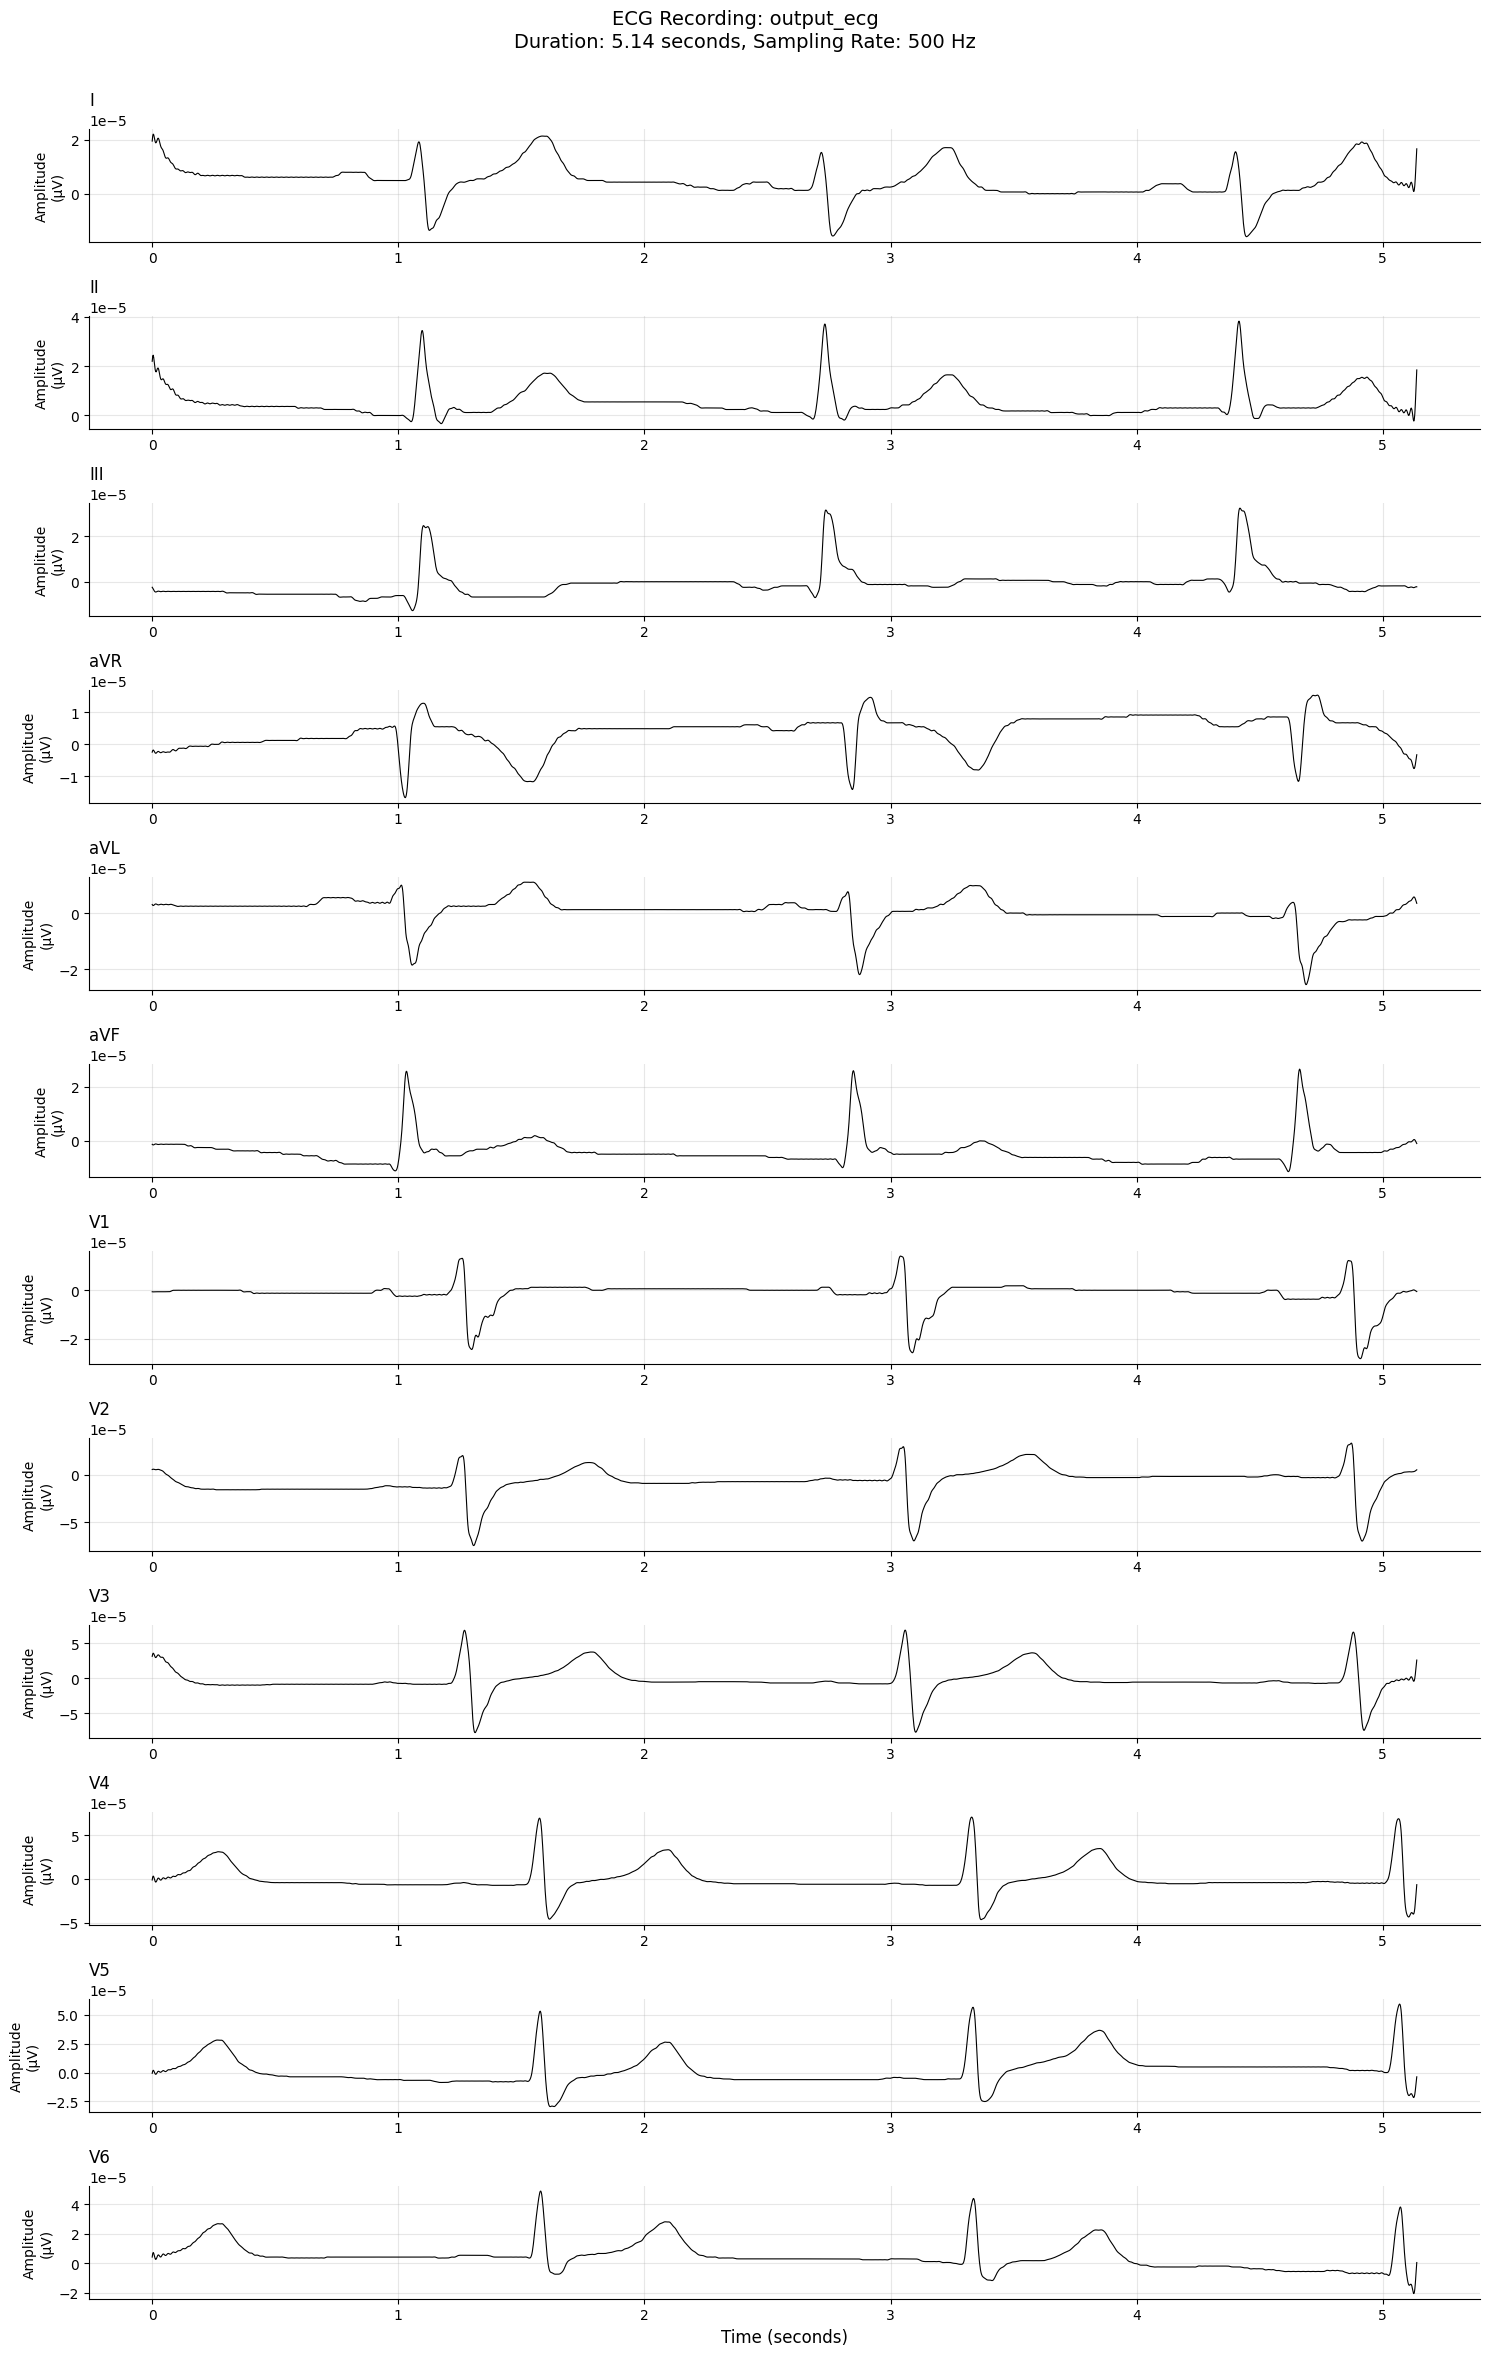

Successfully plotted 12 channels from 5.14 seconds of data
WFDB Record Info:
Record name: output_ecg
Channels: 12
Channel names: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
Sampling frequency: 500 Hz
Duration: 5.14 seconds
Data shape: (2569, 12)
Comments: ['Converted from EDF using MNE: /content/test_edf_ECG.edf', 'Original sampling rate: 100.00019455290769 Hz', 'Date: 2025-08-20 13:04:44']


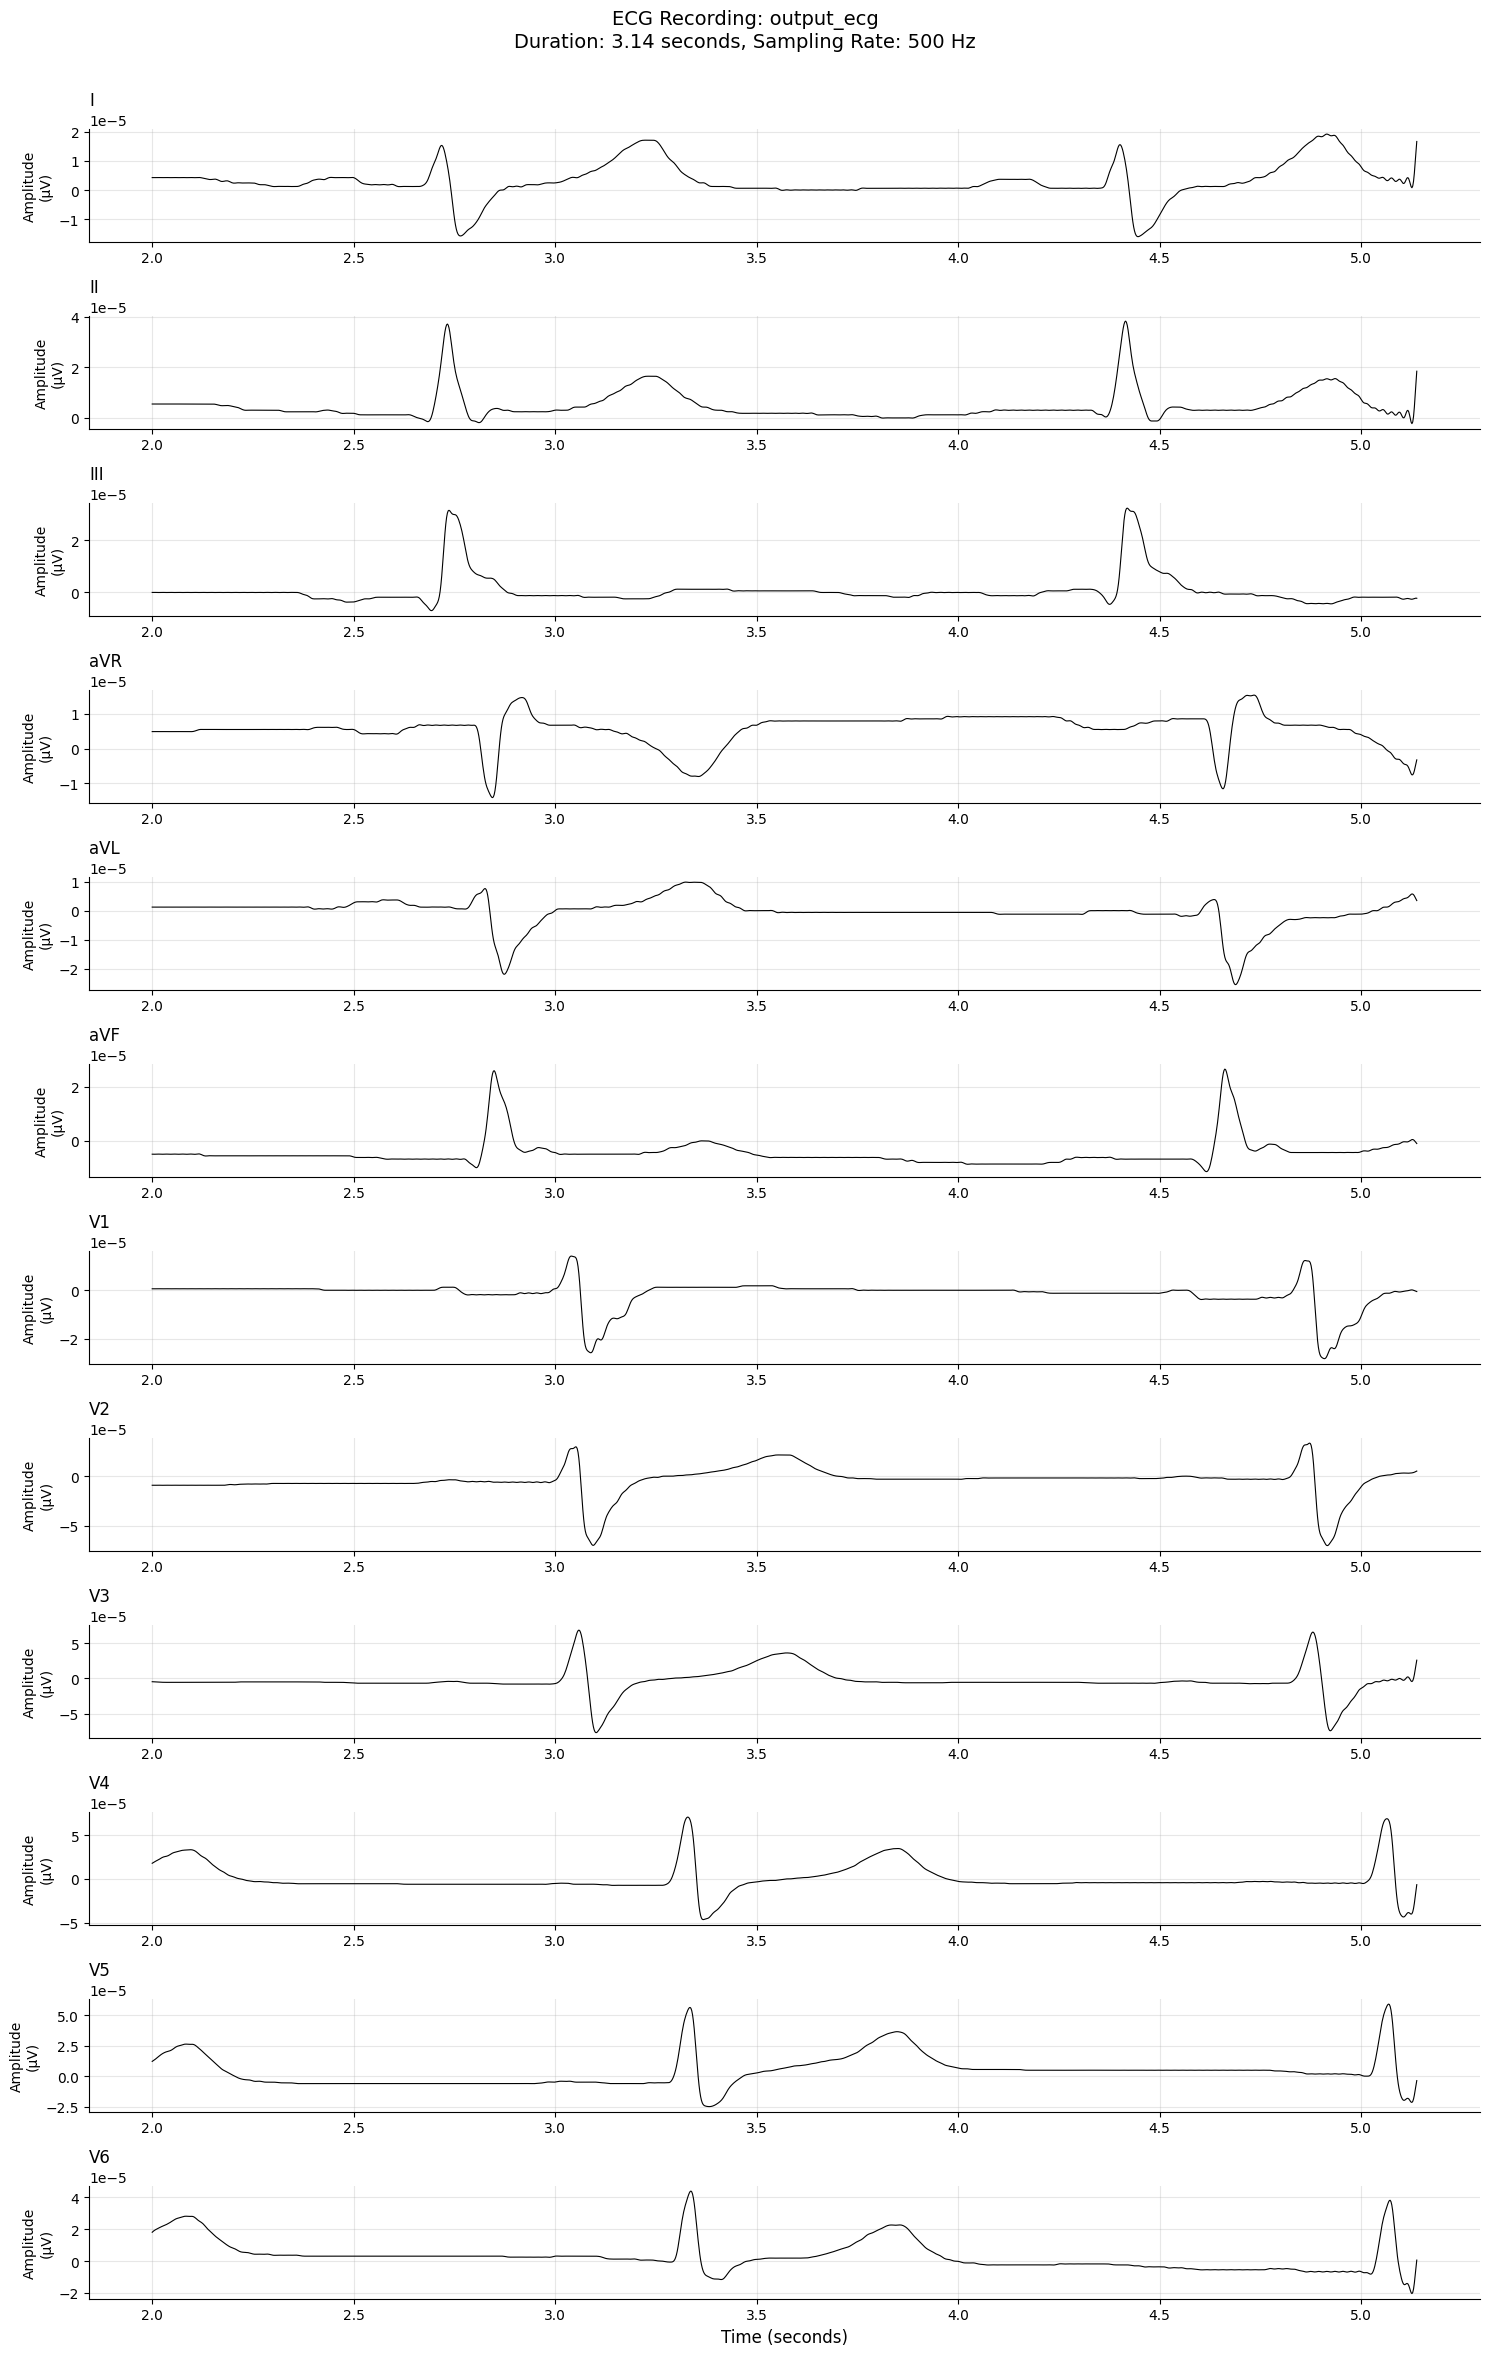

Successfully plotted 12 channels from 3.14 seconds of data
WFDB Record Info:
Record name: output_ecg
Channels: 12
Channel names: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
Sampling frequency: 500 Hz
Duration: 5.14 seconds
Data shape: (2569, 12)
Comments: ['Converted from EDF using MNE: /content/test_edf_ECG.edf', 'Original sampling rate: 100.00019455290769 Hz', 'Date: 2025-08-20 13:04:44']
Plotting first 2 channels for better visualization


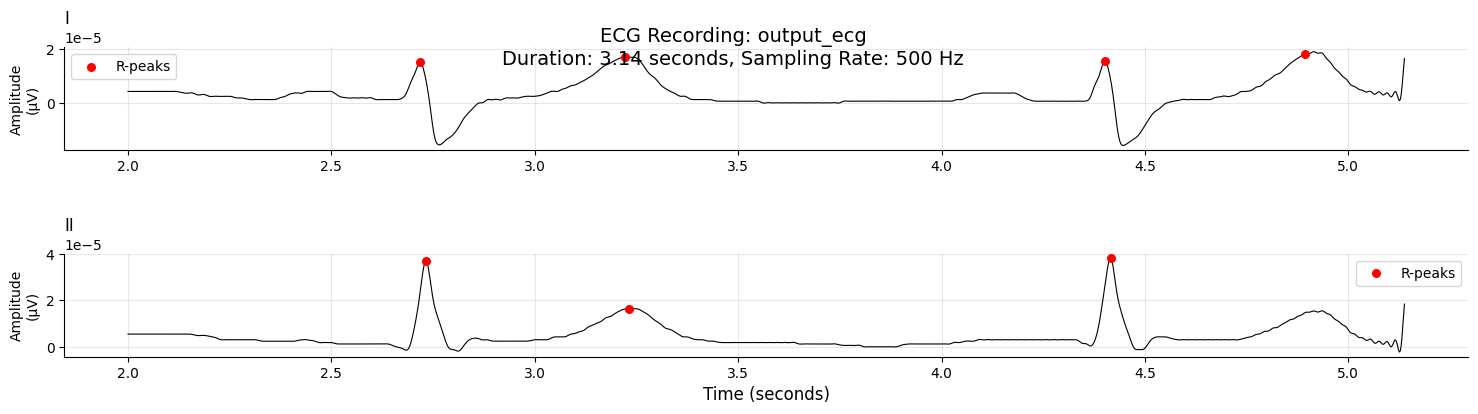

Successfully plotted 2 channels from 3.14 seconds of data
WFDB RECORD INFORMATION: output_ecg
Record Name: output_ecg
Sampling Frequency: 500 Hz
Number of Signals: 12
Number of Samples: 2569
Duration: 5.14 seconds
Signal Names: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
Units: ['uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV', 'uV']
ADC Gain: [112774043319057.4, 103382335492189.97, 95385137066304.72, 134332817947050.94, 117620646080486.28, 113161232056677.25, 102075922188981.22, 39772080765352.836, 29507733158491.113, 36615191897390.71, 48407067251432.13, 61848274502091.04]
Baseline: [-345252194, -1804986325, -935953706, 85244034, 850408382, -864078573, 716284190, 822988709, 130126206, -443023426, -722764161, -881398431]
Initial Value: [1855154995, 464348117, -1168593501, -242372286, 1208979395, -1002047740, 654031369, 1041194632, 1047731187, -487627762, -752233796, -617403816]
Storage Format: ['32', '32', '32', '32', '32', '32', '32', '

In [47]:
# Plot first 10 seconds of ECG
plot_wfdb_record("output_ecg", time_range=(0, 10))

# Plot specific samples
plot_wfdb_record("output_ecg", start_sample=1000, end_sample=6000)

# Plot with R-peak detection on lead II
plot_wfdb_record("output_ecg", time_range=(2, 8), max_channels=2, highlight_r_peaks=True)

# Get detailed information about the record
get_wfdb_info("output_ecg")

# Plot with annotations (if .atr file exists)
plot_wfdb_with_annotations("output_ecg", time_range=(0, 30))